## Import Necssary Libraries

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

## Summary Statistics and Missing-Value Report

In [12]:


try:
    # Load the dataset
    df = pd.read_csv('../data/benin-malanville.csv')

    # Display the first few rows of the dataset
    print("--" * 20)
    print('The first 5 rows of the dataset:')
    display(df.head())
    
    # The description of the categorical columns
    print("--" * 20)
    print('The description of the categorical columns:')
    print(df.describe(include=['object']))

    # Time Range Analysis
    print("\nTime Range Analysis:")
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    print("Earliest Timestamp:", df['Timestamp'].min())
    print("Latest Timestamp:", df['Timestamp'].max())
    
    # check for missing values
    print("--" * 20)
    print('Check for missing values:')
    print(df.isna().sum())


except FileNotFoundError:
    print("Error: The file '../data/benin-malanville.csv' was not found.")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except pd.errors.ParserError:
    print("Error: The file could not be parsed.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

----------------------------------------
The first 5 rows of the dataset:


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments
0,2021-08-09 00:01,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN
1,2021-08-09 00:02,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN
2,2021-08-09 00:03,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN
3,2021-08-09 00:04,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN
4,2021-08-09 00:05,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN


----------------------------------------
The description of the categorical columns:
               Timestamp
count             525600
unique            525600
top     2022-08-08 23:44
freq                   1

Time Range Analysis:
Earliest Timestamp: 2021-08-09 00:01:00
Latest Timestamp: 2022-08-09 00:00:00
----------------------------------------
Check for missing values:
Timestamp             0
GHI                   0
DNI                   0
DHI                   0
ModA                  0
ModB                  0
Tamb                  0
RH                    0
WS                    0
WSgust                0
WSstdev               0
WD                    0
WDstdev               0
BP                    0
Cleaning              0
Precipitation         0
TModA                 0
TModB                 0
Comments         525600
dtype: int64


## Outlier Detection


In [13]:
from scipy.stats import zscore
import numpy as np

# Columns to check for missing values and outliers
key_columns = ['GHI', 'DNI', 'DHI', 'ModA', 'ModB', 'WS', 'WSgust']

# 1. Handle missing values: impute with median for key columns
for col in key_columns:
    if df[col].isna().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)

# 2. Compute Z-scores and flag outliers (|Z| > 3)
z_scores = df[key_columns].apply(zscore)
outlier_mask = (np.abs(z_scores) > 3).any(axis=1)
print(f"Number of outlier rows: {outlier_mask.sum()}")

# Optionally, drop outliers
df_clean = df[~outlier_mask].copy()

# 3. Export cleaned DataFrame
df_clean.to_csv('../data/benin_clean.csv', index=False)
print("Cleaned data exported to '../data/benin_clean.csv'.")

Number of outlier rows: 7740
Cleaned data exported to '../data/benin_clean.csv'.


## Time Series Analysis

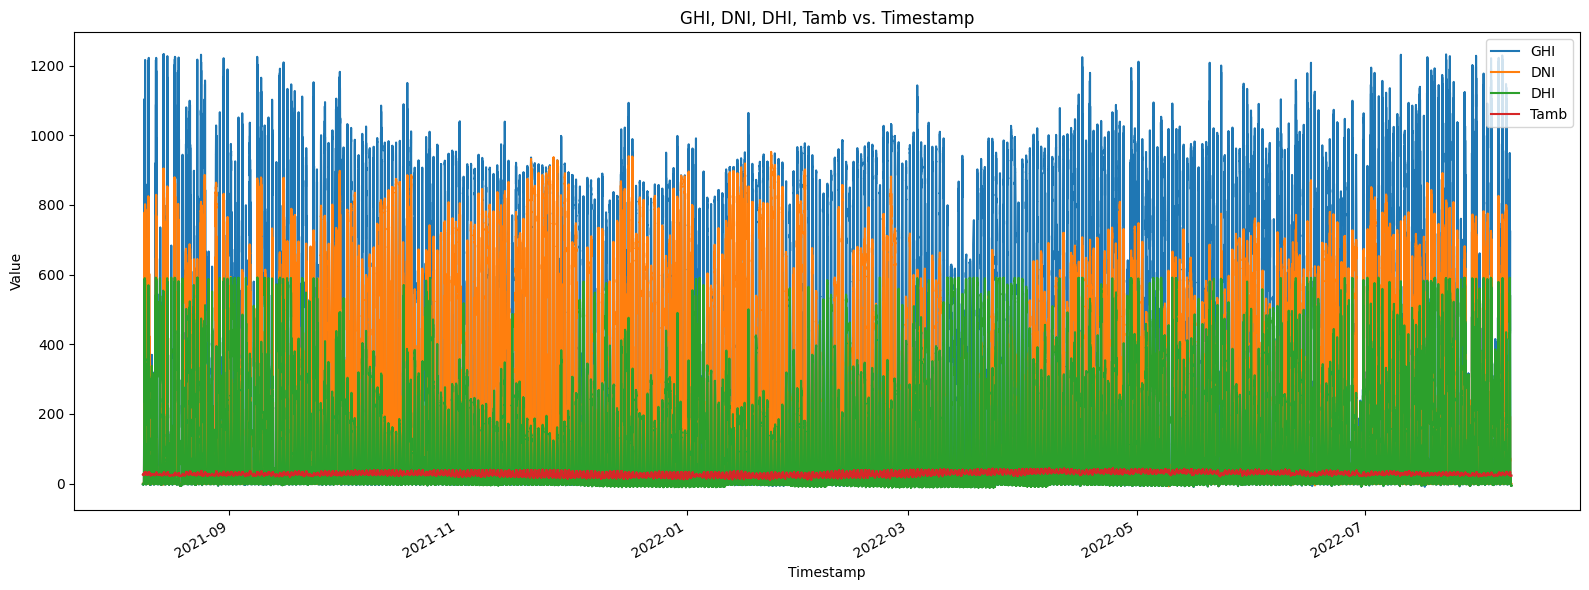

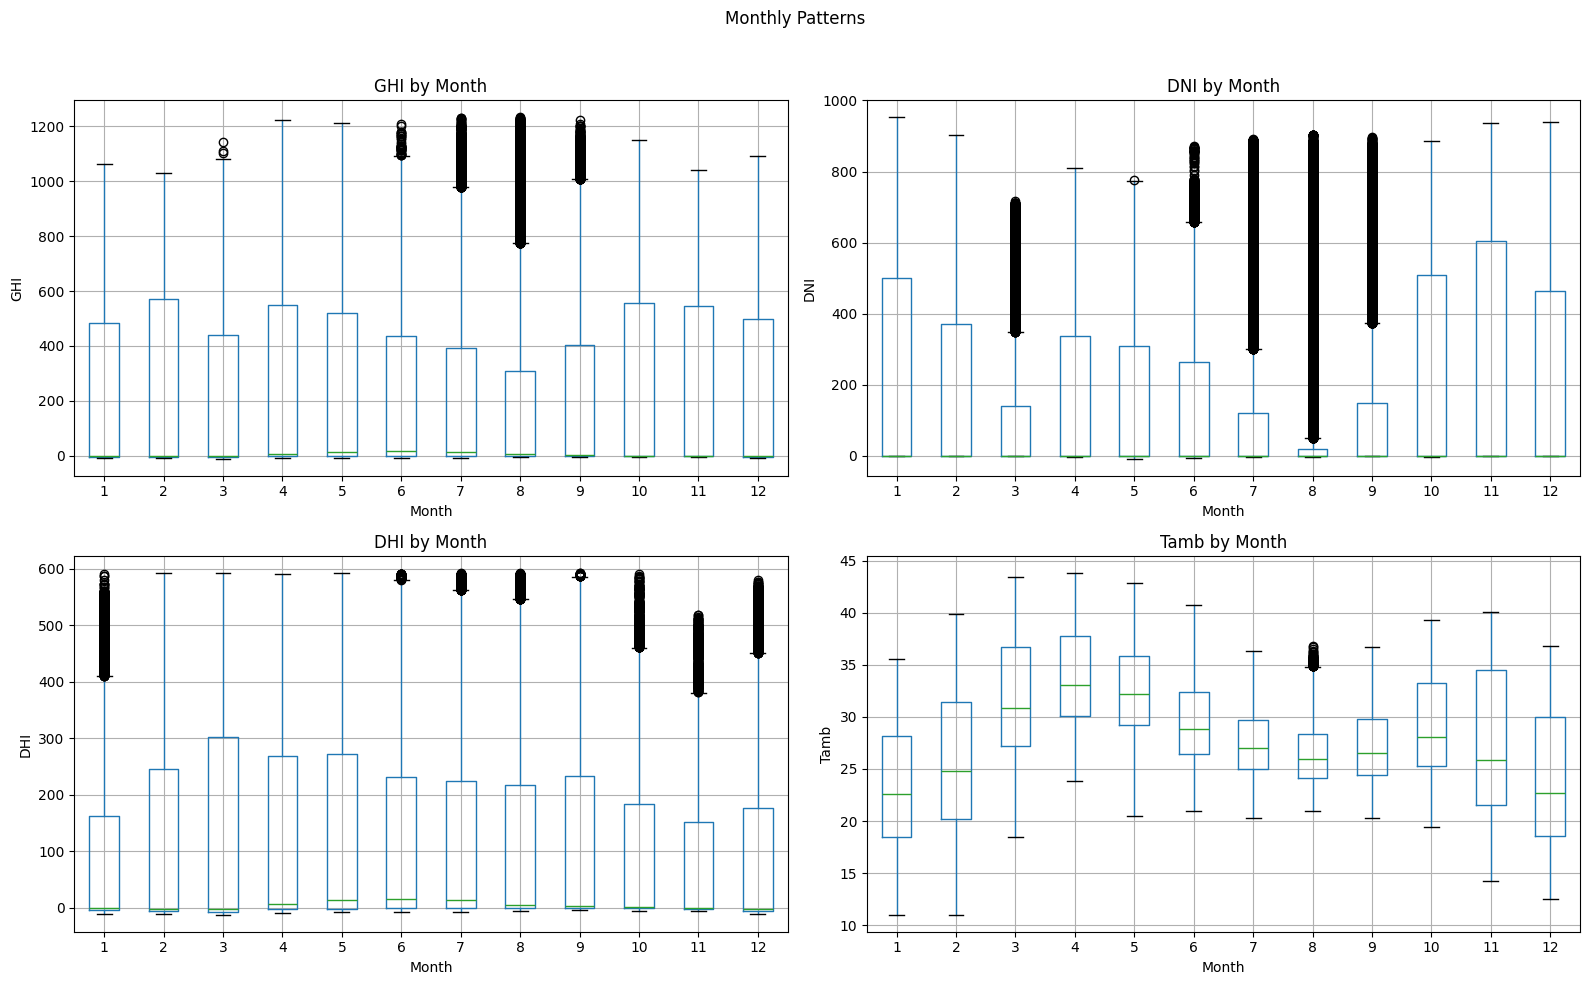

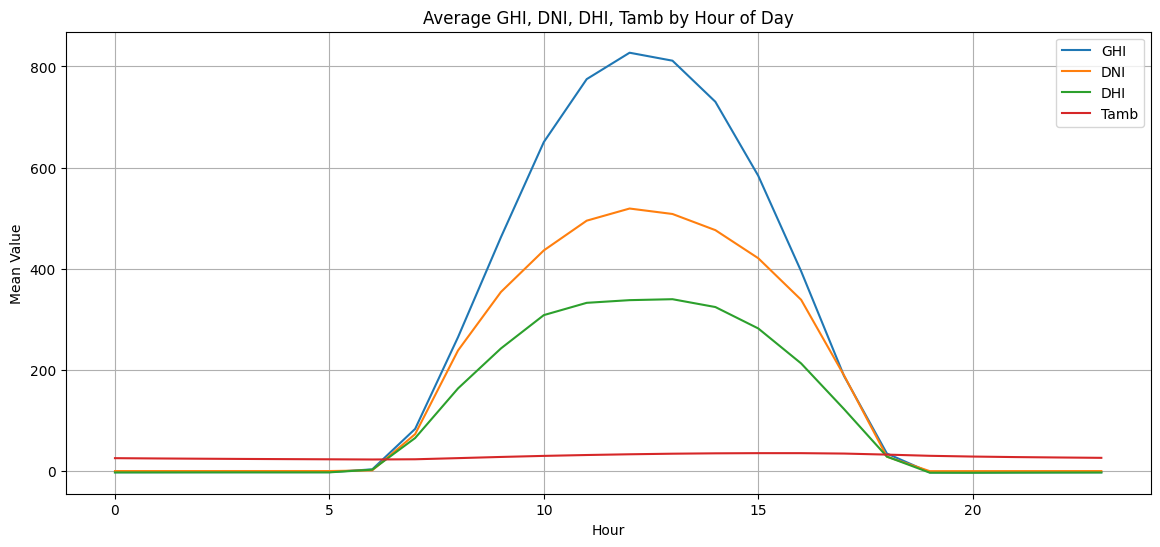

In [14]:
# Plot GHI, DNI, DHI, Tamb vs. Timestamp (line chart)
fig, ax1 = plt.subplots(figsize=(16, 6))

df_clean.set_index('Timestamp')[['GHI', 'DNI', 'DHI', 'Tamb']].plot(ax=ax1)
ax1.set_ylabel('Value')
ax1.set_title('GHI, DNI, DHI, Tamb vs. Timestamp')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Monthly patterns: boxplot by month
df_clean['Month'] = df_clean['Timestamp'].dt.month
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for i, col in enumerate(['GHI', 'DNI', 'DHI', 'Tamb']):
    ax = axes[i//2, i%2]
    df_clean.boxplot(column=col, by='Month', ax=ax)
    ax.set_title(f'{col} by Month')
    ax.set_xlabel('Month')
    ax.set_ylabel(col)
plt.suptitle('Monthly Patterns')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Daily trends: average by hour of day
df_clean['Hour'] = df_clean['Timestamp'].dt.hour
hourly_means = df_clean.groupby('Hour')[['GHI', 'DNI', 'DHI', 'Tamb']].mean()
hourly_means.plot(figsize=(14, 6))
plt.title('Average GHI, DNI, DHI, Tamb by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Mean Value')
plt.grid(True)
plt.show()

## Cleaning Impact

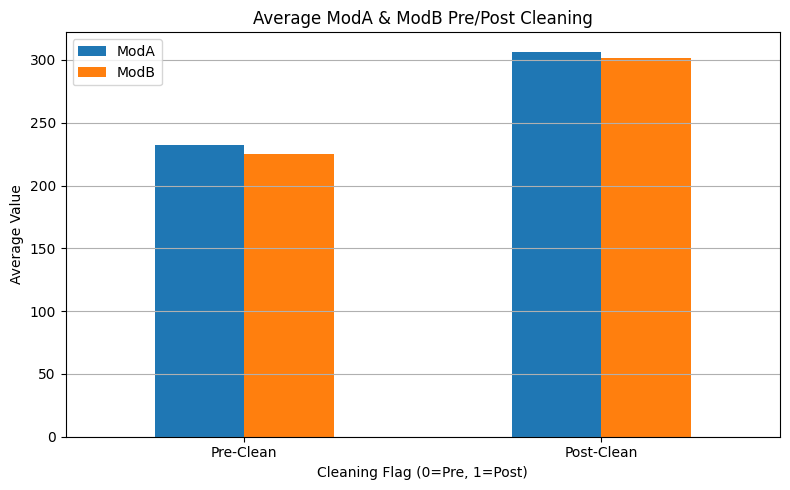

In [15]:
# Group by 'Cleaning' flag and calculate mean for ModA and ModB
cleaning_means = df_clean.groupby('Cleaning')[['ModA', 'ModB']].mean()

# Plot the results
cleaning_means.plot(kind='bar', figsize=(8, 5))
plt.title('Average ModA & ModB Pre/Post Cleaning')
plt.xlabel('Cleaning Flag (0=Pre, 1=Post)')
plt.ylabel('Average Value')
plt.xticks([0, 1], ['Pre-Clean', 'Post-Clean'], rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

## Correlation & Relationship Analysis

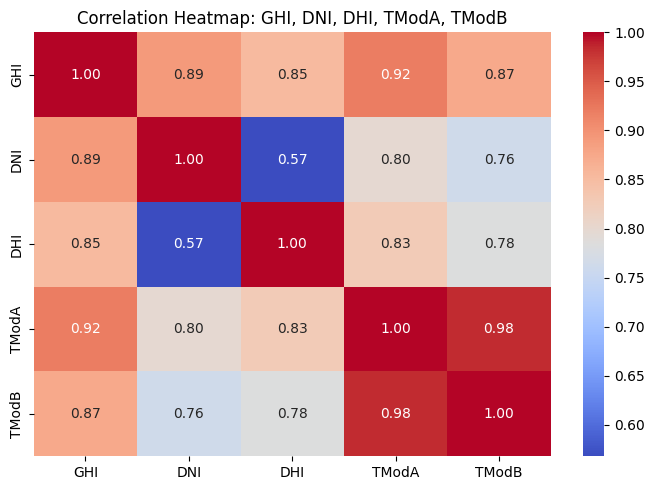

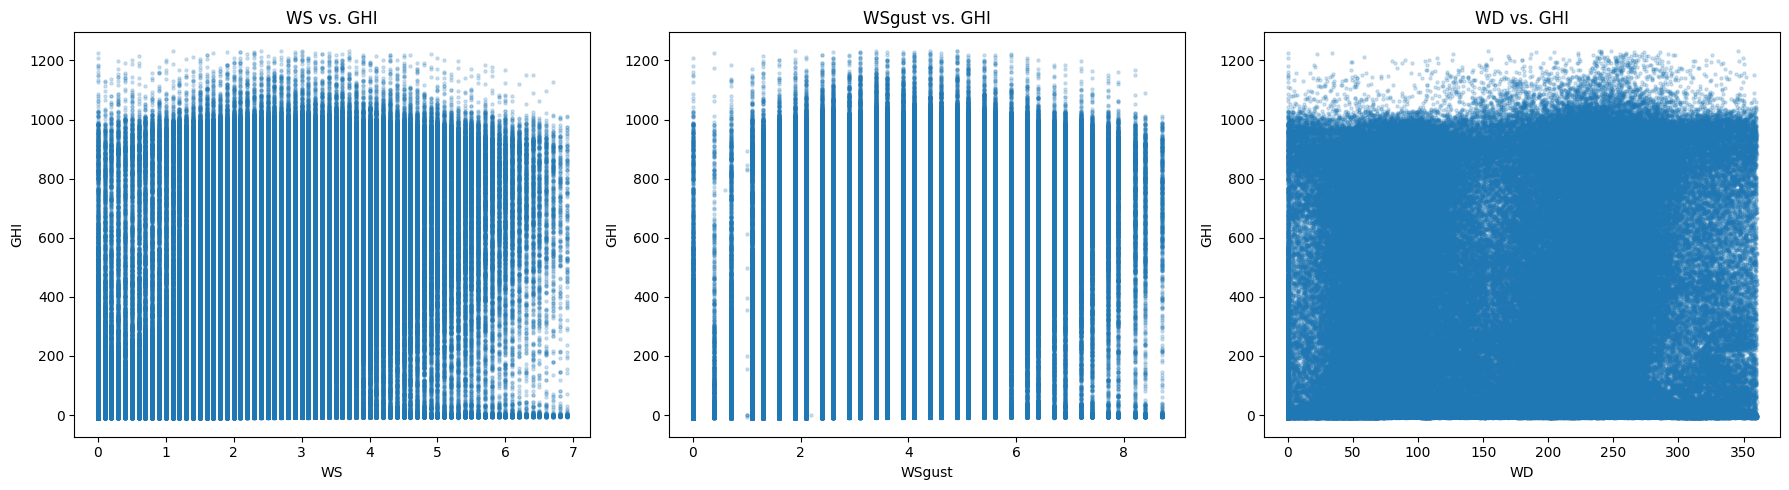

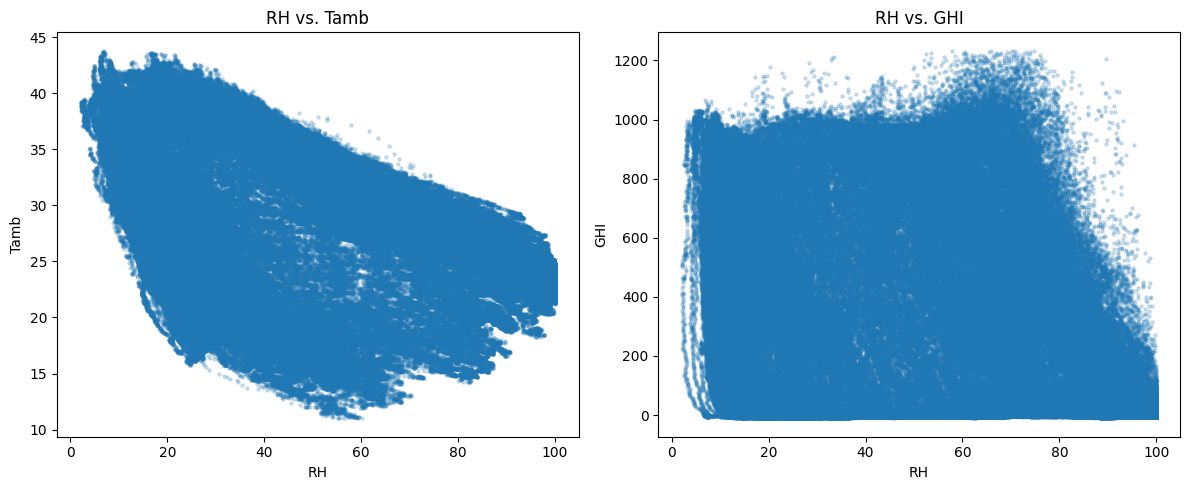

In [16]:
import seaborn as sns

# 1. Correlation heatmap for selected columns
corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
corr_matrix = df_clean[corr_cols].corr()

plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap: GHI, DNI, DHI, TModA, TModB')
plt.tight_layout()
plt.show()

# 2. Scatter plots: WS, WSgust, WD vs. GHI
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, col in zip(axes, ['WS', 'WSgust', 'WD']):
    ax.scatter(df_clean[col], df_clean['GHI'], alpha=0.2, s=5)
    ax.set_xlabel(col)
    ax.set_ylabel('GHI')
    ax.set_title(f'{col} vs. GHI')
plt.tight_layout()
plt.show()

# 3. Scatter plots: RH vs. Tamb and RH vs. GHI
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(df_clean['RH'], df_clean['Tamb'], alpha=0.2, s=5)
axes[0].set_xlabel('RH')
axes[0].set_ylabel('Tamb')
axes[0].set_title('RH vs. Tamb')

axes[1].scatter(df_clean['RH'], df_clean['GHI'], alpha=0.2, s=5)
axes[1].set_xlabel('RH')
axes[1].set_ylabel('GHI')
axes[1].set_title('RH vs. GHI')

plt.tight_layout()
plt.show()

## Wind & Distribution Analysis

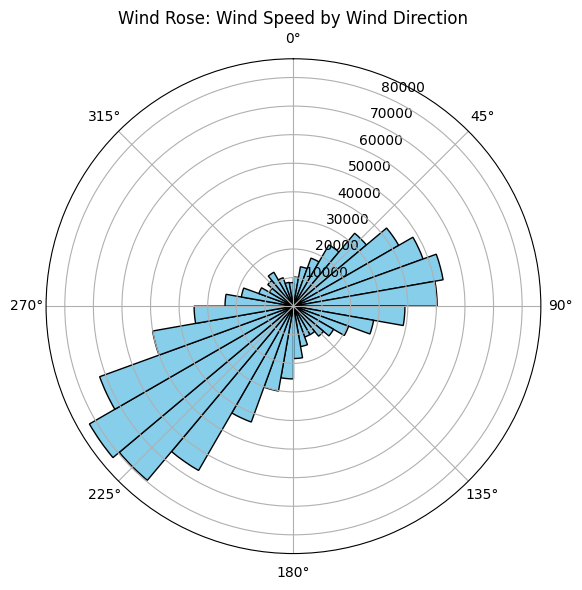

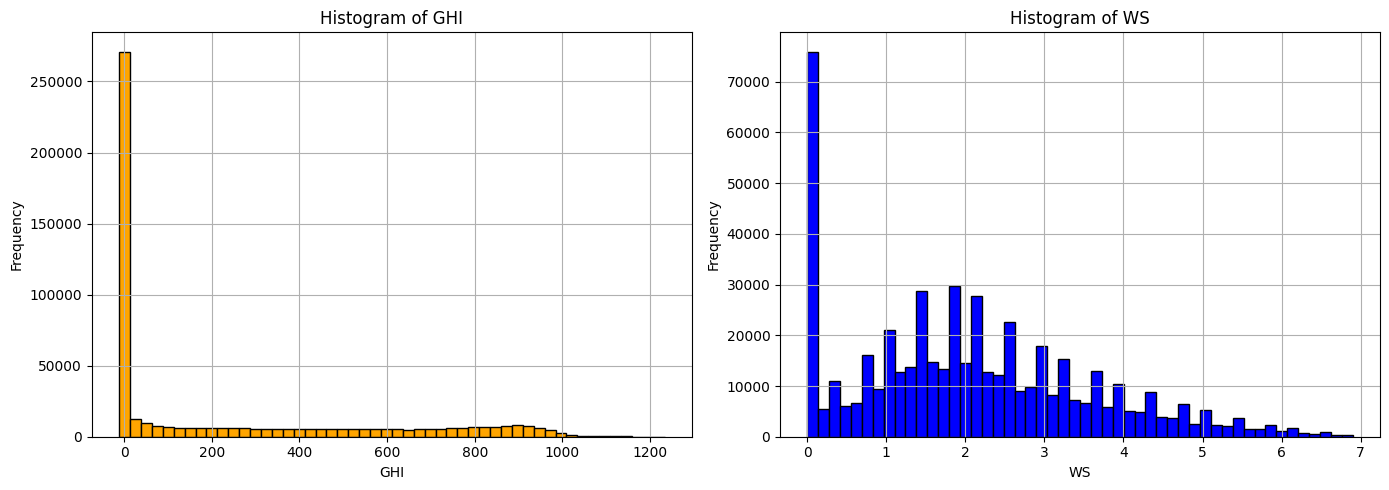

In [17]:
from matplotlib.projections import PolarAxes

# Wind rose (radial bar plot) for WS (wind speed) and WD (wind direction)

# Prepare wind direction in radians and wind speed
wd_rad = np.deg2rad(df_clean['WD'])
ws = df_clean['WS']

# Bin wind direction into 36 bins (every 10 degrees)
wd_bins = np.linspace(0, 360, 37)
ws_bins = np.linspace(ws.min(), ws.max(), 7)

# Create wind rose using matplotlib
fig_windrose = plt.figure(figsize=(8, 6))
ax_windrose = plt.subplot(111, polar=True)
bars = ax_windrose.hist(wd_rad, bins=wd_bins.size-1, weights=ws, color='skyblue', edgecolor='k')
ax_windrose.set_theta_zero_location('N')
ax_windrose.set_theta_direction(-1)
ax_windrose.set_title('Wind Rose: Wind Speed by Wind Direction')
plt.tight_layout()
plt.show()

# Histograms for GHI and WS
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
df_clean['GHI'].hist(ax=axes[0], bins=50, color='orange', edgecolor='black')
axes[0].set_title('Histogram of GHI')
axes[0].set_xlabel('GHI')
axes[0].set_ylabel('Frequency')

df_clean['WS'].hist(ax=axes[1], bins=50, color='blue', edgecolor='black')
axes[1].set_title('Histogram of WS')
axes[1].set_xlabel('WS')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Temperature Analysis

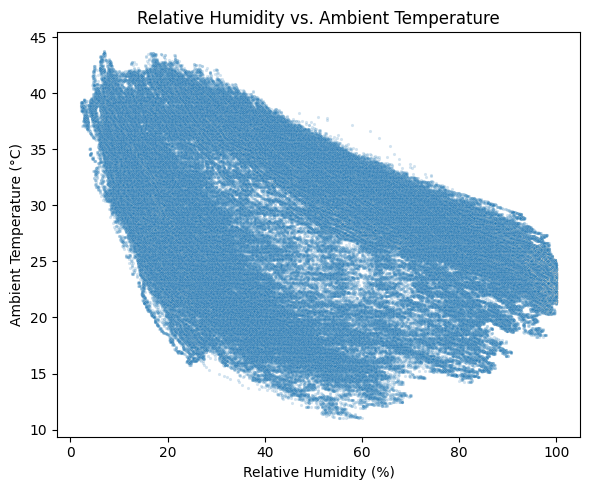

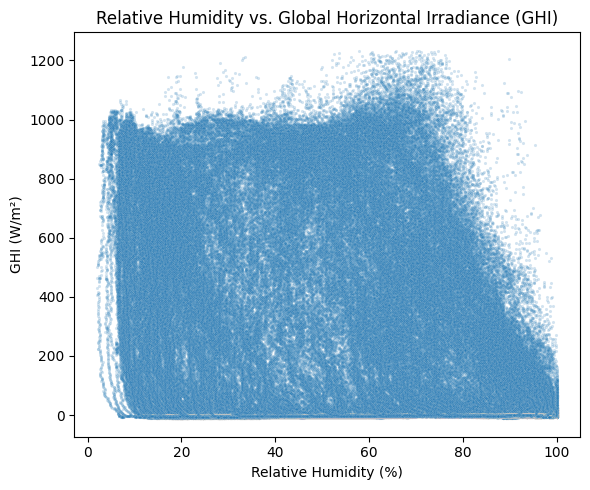

Correlation between RH and Tamb: -0.410
Correlation between RH and GHI: -0.354


In [18]:
import seaborn as sns

# Analyze the relationship between Relative Humidity (RH), Temperature (Tamb), and Solar Radiation (GHI)

# 1. Scatter plot: RH vs. Tamb
plt.figure(figsize=(6, 5))
sns.scatterplot(x='RH', y='Tamb', data=df_clean, alpha=0.2, s=5)
plt.title('Relative Humidity vs. Ambient Temperature')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('Ambient Temperature (°C)')
plt.tight_layout()
plt.show()

# 2. Scatter plot: RH vs. GHI
plt.figure(figsize=(6, 5))
sns.scatterplot(x='RH', y='GHI', data=df_clean, alpha=0.2, s=5)
plt.title('Relative Humidity vs. Global Horizontal Irradiance (GHI)')
plt.xlabel('Relative Humidity (%)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()

# 3. Correlation coefficients
corr_rh_tamb = df_clean['RH'].corr(df_clean['Tamb'])
corr_rh_ghi = df_clean['RH'].corr(df_clean['GHI'])
print(f"Correlation between RH and Tamb: {corr_rh_tamb:.3f}")
print(f"Correlation between RH and GHI: {corr_rh_ghi:.3f}")

## Bubble Chart

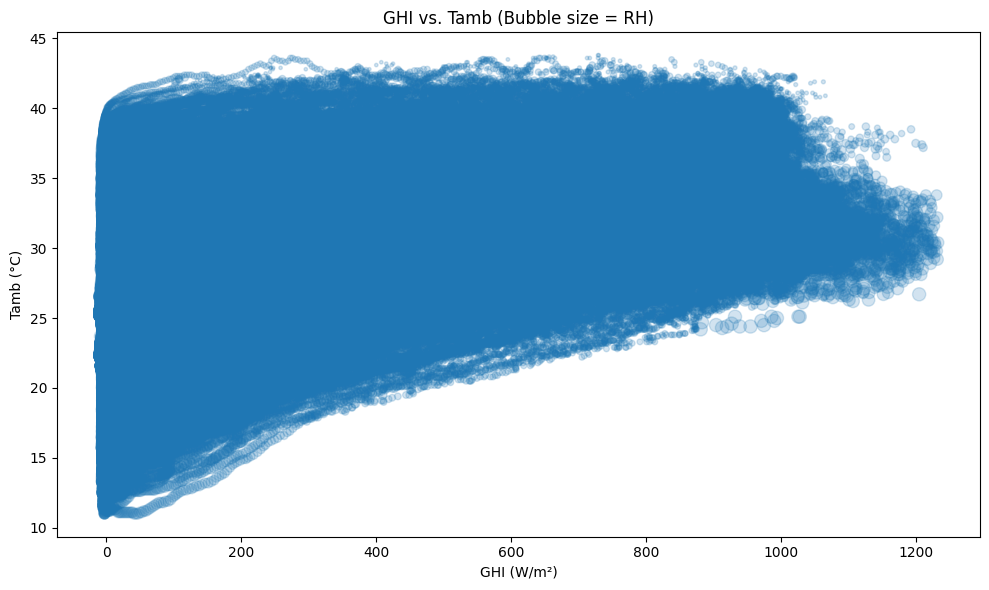

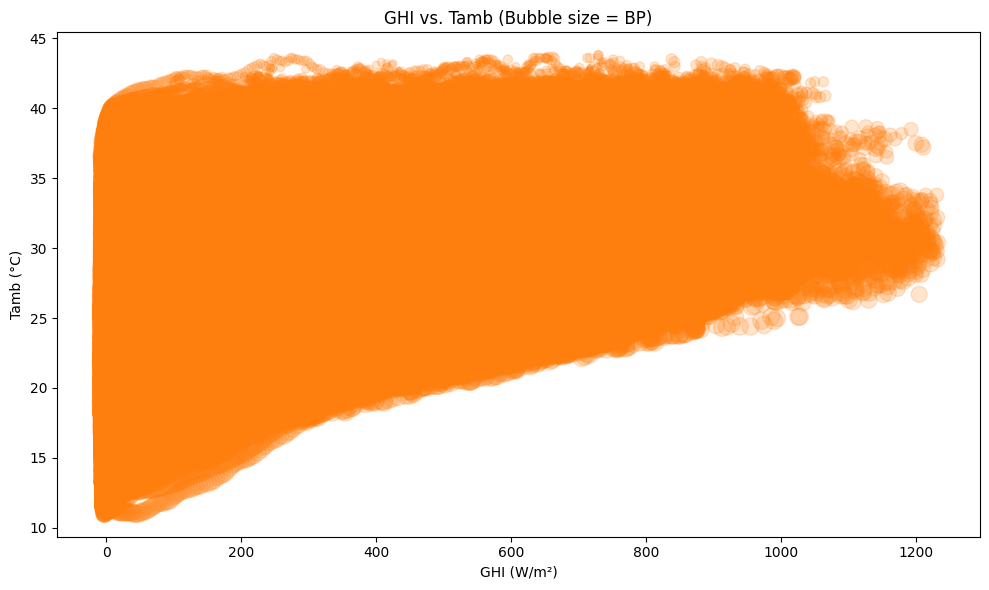

In [19]:
# Bubble chart: GHI vs. Tamb, bubble size by RH and BP

plt.figure(figsize=(10, 6))

# Bubble size by RH (Relative Humidity)
plt.scatter(df_clean['GHI'], df_clean['Tamb'], 
            s=df_clean['RH'],  # size by RH
            alpha=0.2, c='tab:blue', label='Bubble size = RH')

plt.xlabel('GHI (W/m²)')
plt.ylabel('Tamb (°C)')
plt.title('GHI vs. Tamb (Bubble size = RH)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

# Bubble size by BP (Barometric Pressure)
plt.scatter(df_clean['GHI'], df_clean['Tamb'], 
            s=(df_clean['BP'] - df_clean['BP'].min()) / (df_clean['BP'].max() - df_clean['BP'].min()) * 200 + 10,  # scaled BP
            alpha=0.2, c='tab:orange', label='Bubble size = BP')

plt.xlabel('GHI (W/m²)')
plt.ylabel('Tamb (°C)')
plt.title('GHI vs. Tamb (Bubble size = BP)')
plt.tight_layout()
plt.show()